## Notebook under construction

## Playground to understand time dilitated networks

* Demonstrates one-dimensional (dilated) causal convolutions 
* Shows that dilated causal convolution can capture long-range dependencies

<a href="https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/1dconv_demo.ipynb"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="open in colab">
</a>
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_02/1dconv_demo.ipynb)

In [1]:
from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, Dense, Dropout, Lambda, concatenate
from keras.optimizers import Adam
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### A simple toy example

#### Creation of the training data

We produce training data with two different time scales and a bit of noise. 

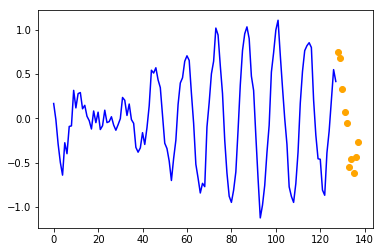

In [4]:
np.random.seed(1) # Fixing the seed, so that data is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1): # We create 1000 data-points
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
    #d[i,:,0] = np.sin(start + np.linspace(0, 5*np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(1):
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

#plt.savefig('ch02_31.pdf')

In [5]:
X.shape, Y.shape

((1000, 128, 1), (1000, 10, 1))

In [6]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]
  
model1 = Sequential()
ks = 5
model1.add(layers.Conv1D(filters=32, kernel_size=ks, padding='causal', input_shape=(None, 1)))
model1.add(layers.Conv1D(filters=32, kernel_size=ks, padding='causal'))
model1.add(layers.Conv1D(filters=32, kernel_size=ks, padding='causal'))
model1.add(layers.Conv1D(filters=32, kernel_size=ks, padding='causal'))
model1.add(layers.Dense(1))
model1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
print("Shape of training data",X.shape, Y.shape)

model1.summary()
model1.compile(optimizer=Adam(), loss='mean_squared_error')


history1 = model1.fit(X[0:800], Y[0:800],
                    epochs=100,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=0)

Shape of training data (1000, 128, 1) (1000, 10, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           33        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
____________________

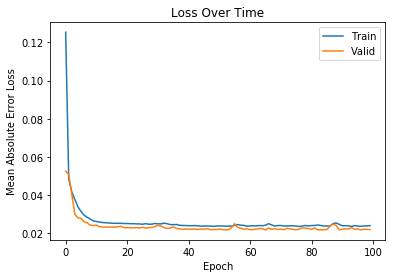

In [7]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [8]:
# Testing
X,Y = gen_data(noise=0)
res = model1.predict(X) 
print('Shapes X {} Y{} res{}'.format(X.shape, Y.shape, res.shape))
print('MSE for complete look-ahead ', np.average((res[:,:,0] - Y[:,:,0])**2)) 
print('MSE for one step look-ahead ', np.average((res[:,0,0] - Y[:,0,0])**2)) 
print('MSE baseline (same as last)', np.average((X[:,-1,0] - Y[:,0,0])**2)) 
[np.average((res[:,i,0] - Y[:,i,0])**2) for i in range(10)]

Shapes X (1000, 128, 1) Y(1000, 10, 1) res(1000, 10, 1)
MSE for complete look-ahead  0.006267331295592429
MSE for one step look-ahead  0.011925456677985275
MSE baseline (same as last) 0.062268842238110335


[0.011925456677985275,
 0.005008001430100228,
 0.002917800504672491,
 0.004766744830107911,
 0.007310097551243553,
 0.007617947646082483,
 0.005374482072015894,
 0.003123674813952852,
 0.004279201182247448,
 0.010349906247516158]

In [9]:
x_test,y_test = gen_data(size=1,noise=0.0)
model1.predict(x_test).reshape(-1),y_test.reshape(-1)

(array([ 0.83867383,  0.7417534 ,  0.50577563,  0.18352611, -0.15598877,
        -0.442437  , -0.61886847, -0.6531378 , -0.5437224 , -0.3188981 ],
       dtype=float32),
 array([ 0.72895423,  0.64760593,  0.43807204,  0.1491152 , -0.1562146 ,
        -0.41442124, -0.57489275, -0.60989633, -0.51924818, -0.3289021 ]))

In [10]:
# Prediction one after another
def predict_sequence(input_sequence, model, pred_steps):

    history_sequence = input_sequence.copy()
    pred_sequence = np.zeros((1,pred_steps * look_ahead,1)) # initialize output (pred_steps time steps)  
    
    for i in range(pred_steps):
        
        # record next time step prediction (last time step of model output) 
        last_step_pred = model.predict(history_sequence)[0,-look_ahead:,0]
        pred_sequence[0,(i * look_ahead) : ((i+1) * look_ahead),0] = last_step_pred
        
        # add the next time step prediction to the history sequence
        history_sequence = np.concatenate([history_sequence, 
                                           last_step_pred.reshape(-1,look_ahead,1)], axis=1)

    return pred_sequence

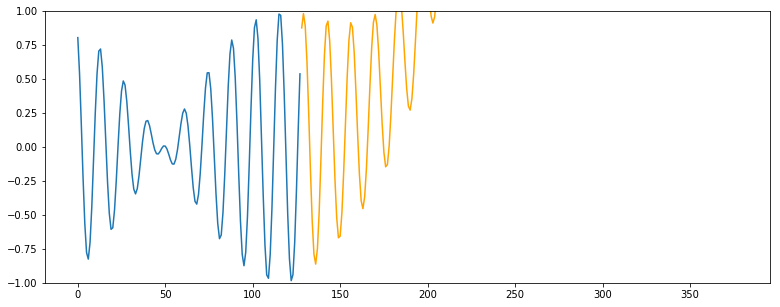

In [11]:
plt.figure(num=None, figsize=(13,5))
pred_steps = 25
x_test,y_test = gen_data(size=1,noise=0.0)
preds = predict_sequence(x_test, model1, pred_steps)
plt.plot(range(0,len(x_test[0])),x_test[0,:,0])
plt.plot(range(len(x_test[0]),len(x_test[0])+len(preds[0])),preds[0,:,0],color='orange')
#plt.plot(range(len(x_test[0]),len(x_test[0])+len(y_test[0])),y_test[0,:,0],color='blue',linestyle='dashed')
plt.ylim((-1,1))
plt.savefig('ch02_32.pdf')

In [12]:
modeldil = Sequential()
#<------ Just replaced this block
modeldil.add(layers.Conv1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=1, 
                           input_shape=(None, 1)))
modeldil.add(layers.Conv1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=2))
modeldil.add(layers.Conv1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=4))
modeldil.add(layers.Conv1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=8))
#<------ Just replaced this block

modeldil.add(layers.Dense(1))
modeldil.add(Lambda(slice, arguments={'slice_length':look_ahead}))

modeldil.summary()
modeldil.compile(optimizer=Adam(),
              #loss='mean_absolute_error',
              loss='mean_squared_error'
                )

print(X.shape, Y.shape)
histdil = modeldil.fit(X[0:800], Y[0:800],
                    epochs=200,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]), verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           33        
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________________________
(1000,

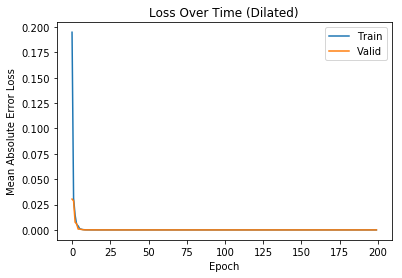

In [13]:
plt.plot(histdil.history['loss'])
plt.plot(histdil.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time (Dilated)')
plt.legend(['Train','Valid'])

In [14]:
# Testing
X,Y = gen_data()
res = modeldil.predict(X) 
print('MSE for one step look-ahead ', np.average((res[:,0,0] - Y[:,0,0])**2)) #One step look-ahead prediction
print('MSE baseline (same as last)', np.average((X[:,-1,0] - Y[:,0,0])**2)) 

MSE for one step look-ahead  0.012838626396439824
MSE baseline (same as last) 0.08322322112113202


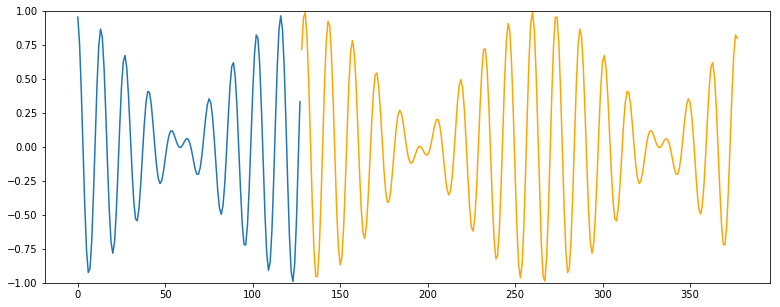

In [16]:
plt.figure(num=None, figsize=(13,5))
pred_steps = 25
x_test,y_test = gen_data(size=1,noise=0.0)
preds = predict_sequence(x_test, modeldil, pred_steps)
plt.plot(range(0,len(x_test[0])),x_test[0,:,0])
plt.plot(range(len(x_test[0]),len(x_test[0])+len(preds[0])),preds[0,:,0],color='orange')
#plt.plot(range(len(x_test[0]),len(x_test[0])+len(y_test[0])),y_test[0,:,0],color='blue',linestyle='dashed')
plt.ylim((-1,1))
plt.savefig('ch02_33.pdf')

### Understanding Causal Padding

Below is a simple example to show that convolutions is made causal by  padding.

We use a single 1 dimensional kernel 1,2 and as input the sequence 10,20,30. Causal padding simply does the following

00,10,20,30
  1,2

resulting in
 
 20, 50, 80

In [14]:
model = Sequential()
model.add(Conv1D(filters=1, 
                 kernel_size=2, 
                 padding='causal', 
                 dilation_rate=1,
                 use_bias=False,
                 input_shape=(3, 1))
         )

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 3, 1)              2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [15]:
#print(model.get_weights())
model.set_weights([np.asarray([[[1]],[[2]]])])
print(model.get_weights())

[array([[[1.]],

       [[2.]]], dtype=float32)]


In [16]:
x_in = np.reshape(np.linspace(10,30,3), (1,3,1))
print(x_in)
model.predict(x_in)

[[[10.]
  [20.]
  [30.]]]


array([[[20.],
        [50.],
        [80.]]], dtype=float32)